In [84]:
import sklearn
import pandas as pd

In [85]:
import pandas as pd
import pickle

with open('../yk_dataframes.pkl', 'rb') as file:
    yk_data = pickle.load(file)
yk_full = yk_data['yk_full']
yk_dropped = yk_data['yk_dropped']

with open('../ty_dataframes.pkl', 'rb') as file:
    ty_data = pickle.load(file)
ty_full = ty_data['ty_full']
ty_dropped = ty_data['ty_dropped']


with open('../luna_dataframes.pkl', 'rb') as file:
    luna_data = pickle.load(file)
luna_full = luna_data['luna_full']
luna_dropped = luna_data['luna_dropped']

In [91]:
df_full = pd.concat([yk_full, ty_full, luna_full], axis=0)
df_full[df_full.isnull().any(axis=1)].shape[0]

3

In [90]:
df_full_filled = df_full.fillna(0)
df_full_filled.shape

(5797, 42)

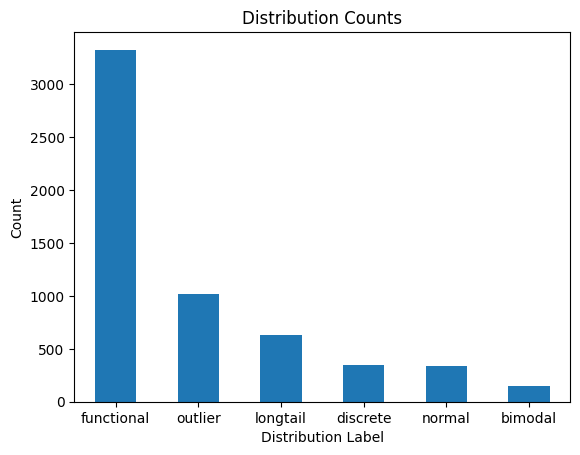

In [92]:
distribution_counts = df_full_filled['Distribution Type'].value_counts()

import matplotlib.pyplot as plt

distribution_counts.plot(kind='bar')
plt.title('Distribution Counts')
plt.xlabel('Distribution Label')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

In [93]:
from sklearn.model_selection import train_test_split

columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X = df_full_filled.drop(columns = columns_to_drop)
y = df_full_filled['Target_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [97]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.968103448275862
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       832
           1       0.96      0.92      0.94       328

    accuracy                           0.97      1160
   macro avg       0.97      0.95      0.96      1160
weighted avg       0.97      0.97      0.97      1160



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

In [15]:
best_params = grid_search.best_params_

tuned_model = RandomForestClassifier(**best_params)

tuned_model.fit(X_train, y_train)
y_pred_tuned = model.predict(X_test)

In [16]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))

Accuracy: 0.9690721649484536
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       859
           1       0.95      0.93      0.94       305

    accuracy                           0.97      1164
   macro avg       0.96      0.96      0.96      1164
weighted avg       0.97      0.97      0.97      1164



In [99]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [107]:
model_smote = RandomForestClassifier() # class_weight={0: 1, 1: 10}
model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_test)
y_pred_smote_adjusted = (model_smote.predict_proba(X_test)[:, 1] >= 0.51).astype(int) # f1_threshold calculated below

In [108]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))

print("Accuracy:", accuracy_score(y_test, y_pred_smote_adjusted))
print("Classification Report:\n", classification_report(y_test, y_pred_smote_adjusted))

Accuracy: 0.9672413793103448
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       832
           1       0.94      0.94      0.94       328

    accuracy                           0.97      1160
   macro avg       0.96      0.96      0.96      1160
weighted avg       0.97      0.97      0.97      1160

Accuracy: 0.9672413793103448
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       832
           1       0.94      0.94      0.94       328

    accuracy                           0.97      1160
   macro avg       0.96      0.96      0.96      1160
weighted avg       0.97      0.97      0.97      1160



In [269]:
import pickle

with open('luna_model.pkl', 'wb') as file:
    pickle.dump(model_smote, file)

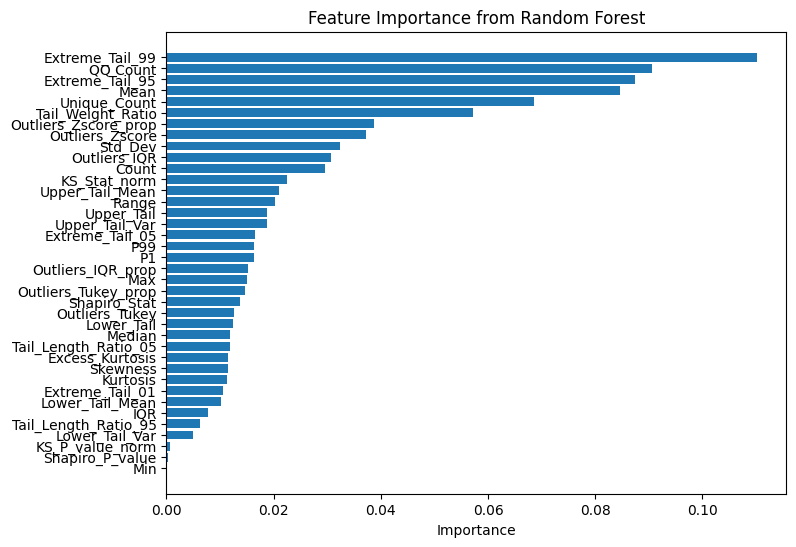

In [41]:
import pandas as pd
import matplotlib as plt

importances = model_smote.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

# Threshold to optimize f1-score and recall

In [104]:
from sklearn.metrics import precision_recall_curve
import numpy as np

y_probs = model_smote.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# best threshold for recall
recall_idx = np.argmax(recalls)
recall_threshold = thresholds[recall_idx]

# best threshld for f1 score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_idx = np.argmax(f1_scores)
f1_threshold = thresholds[f1_idx]

print(recall_threshold)
print(f1_threshold)

0.0
0.51


In [46]:
y_pred_smote_adjusted = (model_smote.predict_proba(X_test)[:, 1] >= f1_threshold).astype(int) # f1_threshold calculated below

In [47]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_smote_adjusted))
print("Classification Report:\n", classification_report(y_test, y_pred_smote_adjusted))

Accuracy: 0.9690721649484536
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       859
           1       0.94      0.95      0.94       305

    accuracy                           0.97      1164
   macro avg       0.96      0.96      0.96      1164
weighted avg       0.97      0.97      0.97      1164



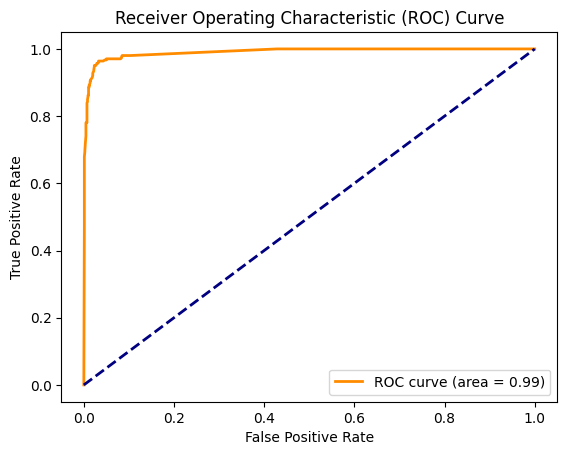

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate probabilities
y_prob = model_smote.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Predict yk data

In [49]:
yk_full_filled = yk_full.fillna(0)

columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X_yk = yk_full_filled.drop(columns = columns_to_drop)
y_yk = yk_full_filled['Target_Encoded']

y_pred_yk = model_smote.predict(X_yk)

In [51]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_yk, y_pred_yk))
print("Classification Report:\n", classification_report(y_yk, y_pred_yk))

Accuracy: 0.9824390243902439
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       490
           1       0.98      0.99      0.98       535

    accuracy                           0.98      1025
   macro avg       0.98      0.98      0.98      1025
weighted avg       0.98      0.98      0.98      1025



# Predict luna data

In [56]:
luna_full_filled = yk_full.fillna(0)

columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X_luna = luna_full_filled.drop(columns = columns_to_drop)
y_luna = luna_full_filled['Target_Encoded']

y_pred_luna = model_smote.predict(X_luna)
y_pred_luna_adjusted = (model_smote.predict_proba(X_luna)[:, 1] >= 0.35).astype(int)

In [57]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_luna, y_pred_luna))
print("Classification Report:\n", classification_report(y_luna, y_pred_luna))

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_luna, y_pred_luna_adjusted))
print("Classification Report:\n", classification_report(y_luna, y_pred_luna_adjusted))

Accuracy: 0.9824390243902439
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       490
           1       0.98      0.99      0.98       535

    accuracy                           0.98      1025
   macro avg       0.98      0.98      0.98      1025
weighted avg       0.98      0.98      0.98      1025

Accuracy: 0.9746341463414634
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       490
           1       0.96      1.00      0.98       535

    accuracy                           0.97      1025
   macro avg       0.98      0.97      0.97      1025
weighted avg       0.98      0.97      0.97      1025



In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_smote, y_train_smote)
xgb_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Classification Report:\n", classification_report(y_test, xgb_pred))

/opt/homebrew/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy: 0.9630584192439863
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       859
           1       0.92      0.94      0.93       305

    accuracy                           0.96      1164
   macro avg       0.95      0.95      0.95      1164
weighted avg       0.96      0.96      0.96      1164



In [59]:
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
svm_model.fit(X_train_smote, y_train_smote)
svm_pred = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, svm_pred))
print("Classification Report:\n", classification_report(y_test, svm_pred))

Accuracy: 0.8634020618556701
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90       859
           1       0.70      0.84      0.76       305

    accuracy                           0.86      1164
   macro avg       0.82      0.86      0.83      1164
weighted avg       0.88      0.86      0.87      1164



In [60]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier

rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()
catboost_model = CatBoostClassifier(learning_rate=0.1, depth=6, iterations=100, verbose=0)
svm_model = SVC(probability=True)

meta_model = LogisticRegression()
#meta_model = DecisionTreeClassifier()
#meta_model = GradientBoostingClassifier()
#meta_model = MLPClassifier()


kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_meta_features = np.zeros((X_train_smote.shape[0], 3)) 
test_meta_features = np.zeros((X_test.shape[0], 3))

for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train_smote.iloc[train_idx], X_train_smote.iloc[val_idx]
    y_tr, y_val = y_train_smote.iloc[train_idx], y_train_smote.iloc[val_idx]

    # Random Forest
    rf_model.fit(X_tr, y_tr)
    train_meta_features[val_idx, 0] = rf_model.predict(X_val)
    test_meta_features[:, 0] += rf_model.predict(X_test) / kf.n_splits

    # XGBoost
    xgb_model.fit(X_tr, y_tr)
    train_meta_features[val_idx, 1] = xgb_model.predict(X_val)
    test_meta_features[:, 1] += xgb_model.predict(X_test) / kf.n_splits

    # CatBoost
    catboost_model.fit(X_tr, y_tr)
    train_meta_features[val_idx, 2] = catboost_model.predict(X_val)
    test_meta_features[:, 2] += catboost_model.predict(X_test) / kf.n_splits

    # SVM
    svm_model.fit(X_tr, y_tr)
    train_meta_features[val_idx, 2] = svm_model.predict(X_val)
    test_meta_features[:, 2] += svm_model.predict(X_test) / kf.n_splits

# train meta-model on the predictions
meta_model.fit(train_meta_features, y_train_smote)
final_predictions = meta_model.predict(test_meta_features)

print("Accuracy:", accuracy_score(y_test, final_predictions))
print("Classification Report:\n", classification_report(y_test, final_predictions))

Accuracy: 0.961340206185567
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       859
           1       0.90      0.96      0.93       305

    accuracy                           0.96      1164
   macro avg       0.94      0.96      0.95      1164
weighted avg       0.96      0.96      0.96      1164



In [64]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_smote, y_train_smote)

log_reg_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, log_reg_pred))
print("Classification Report:\n", classification_report(y_test, log_reg_pred))

Accuracy: 0.8144329896907216
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       859
           1       0.62      0.75      0.68       305

    accuracy                           0.81      1164
   macro avg       0.76      0.79      0.77      1164
weighted avg       0.83      0.81      0.82      1164



/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
from catboost import CatBoostClassifier

cat_clf = CatBoostClassifier(verbose=0)
cat_clf.fit(X_train_smote, y_train_smote)

cat_pred = cat_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, cat_pred))
print("Classification Report:\n", classification_report(y_test, cat_pred))

Accuracy: 0.9647766323024055
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       859
           1       0.92      0.95      0.93       305

    accuracy                           0.96      1164
   macro avg       0.95      0.96      0.96      1164
weighted avg       0.97      0.96      0.97      1164



In [69]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_clf.fit(X_train, y_train)

mlp_pred = mlp_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, mlp_pred))
print("Classification Report:\n", classification_report(y_test, mlp_pred))


Accuracy: 0.8049828178694158
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88       859
           1       0.83      0.32      0.46       305

    accuracy                           0.80      1164
   macro avg       0.82      0.65      0.67      1164
weighted avg       0.81      0.80      0.77      1164



In [72]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train_smote, y_train_smote)

lgbm_pred = lgbm_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, lgbm_pred))
print("Classification Report:\n", classification_report(y_test, lgbm_pred))

OSError: dlopen(/opt/homebrew/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <D3923ACB-D836-32D3-A031-CF91999FDAFC> /opt/homebrew/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file)